In [1]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F
from torch import distributions as pyd

from utils import util, buffer
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from utils import util, buffer
import pickle
# import h5py

import os
from sklearn.decomposition import PCA

In [3]:
a = np.random.randint(0,10,10)
a[np.argsort(a)]

array([0, 0, 2, 4, 4, 5, 7, 8, 8, 8])

In [26]:
  # state_seqs_all: [syllable, state_dim]
  # action_seqs_all: [syllable, action_dim]
from visualize import get_edges, unpack_batch
def plot_sa(state_seq, action_seq):
    edges, state_name, n_dim = get_edges(state_seq.shape[-1])
    fig, axis = plt.subplots(3, 4, figsize=(20, 15))
    n_bodyparts = len(state_name)
    n_sample = state_seq.shape[0]

    state_to_plot = state_seq.reshape(n_sample, -1, 2)
    state_to_plot -= state_to_plot.mean(axis=1, keepdims=True)
    _, eigenval, vhs = np.linalg.svd(state_to_plot)
    head_idx = state_name.index('head')
    n_bodyparts = len(state_name)
    pc1 = vhs[:,0,:] # [batch, 2, 2]
    head_vector = state_to_plot[:, head_idx, :]
    flip_sign1 = np.where(np.sum(head_vector*pc1, axis=-1, keepdims=True) < 0, -1, 1)
    leftear_index = state_name.index('left ear')
    pc2 = vhs[:,1,:]
    leftear_vector = state_to_plot[:, leftear_index, :]
    flip_sign2 = np.where(np.sum(leftear_vector*pc2, axis=-1, keepdims=True) < 0, -1, 1)
    pc1 = pc1 * flip_sign1
    pc2 = pc2 * flip_sign2
    vs_calib = np.stack([pc1, pc2], axis=-1)
    assert vs_calib.shape == (n_sample, 2, 2)
    scale_factor = eigenval[:,0].reshape(n_sample, 1, 1)
    rotating_s = np.matmul(state_to_plot, vs_calib)
    rotating_a = np.matmul(action_seq.reshape(n_sample, -1, 2), vs_calib)
    # s_all = rotating_s.reshape(n_sample, agent.state_dim)
    # a_all = rotating_a.reshape(n_sample, agent.action_dim)

    state_seqs_to_plot = rotating_s
    action_seqs_to_plot = rotating_a
    cmap = plt.cm.get_cmap('viridis')
    keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
    axmin = -0.3
    axmax = 0.3
    aymin = -0.3
    aymax = 0.3
    for j in range(n_sample):
        for p1, p2 in edges:
            axis[j//4, j%4].plot(
                *state_seqs_to_plot[j, (p1, p2)].T,
                color=keypoint_colors[p1],
                linewidth=5.0, zorder=0)
        axis[j//4, j%4].scatter(
            *state_seqs_to_plot[j].T,
            c=keypoint_colors,
            s=100, zorder=0)
        axis[j//4, j%4].set_title(f'{j}', fontsize=30)
        axis[j//4, j%4].axis('off')
        axis[j//4, j%4].set_xlim(axmin, axmax)
        axis[j//4, j%4].set_ylim(aymin, aymax)
        for k in range(n_bodyparts):
            axis[j//4, j%4].quiver(state_seqs_to_plot[j, k, 0], state_seqs_to_plot[j, k, 1], 
                                action_seqs_to_plot[j, k, 0], action_seqs_to_plot[j, k, 1], 
                                angles='xy', scale_units='xy', scale=0.2, color='r', zorder=1)
    plt.tight_layout()
    plt.show()
    return fig, axis
def sample_and_plot(dataset, n_sample):
    all_idx = np.where(dataset.task==2)[0]
    sample_idx = all_idx[np.random.randint(0, len(all_idx), n_sample)]
    # sample_idx = 17387  #Left
    # sample_idx = 67040  #Right
    # sample_idx = np.array([17387, 67040])
    print(f'sample_idx: {sample_idx}')
    state, action, next_state, reward, done, task, next_task = unpack_batch(dataset.take(sample_idx))
    print('action:', action)
    plot_sa(state.numpy(), action.numpy())

sample_idx: [13119 10517 11209 12561  2036  9107  4569  1573 10781  4130]
action: tensor([[ 0.0000,  0.0100, -0.0100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0100, -0.0200,  0.0000, -0.0100,  0.0100,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0200,  0.0000, -0.0100, -0.0100, -0.0100,
         -0.0100,  0.0000, -0.0100, -0.0100,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0100,  0.0000, -0.0100,  0.0000, -0.0100,  0.0000,  0.0000,
          0.0000,  0.0200, -0.0100,  0.0300,  0.0100,  0.0100, -0.0100,  0.0200],
        [ 0.0000, -0.0200,  0.0000, -0.0100,  0.0000,  0.0000,  0.0000,  0.0100,
          0.0100,  0.0200,  0.0000,  0.0300,  0.0100,  0.0200,  0.0000,  0.0200],
        [-0.0100,  0.0000, -0.0100,  0.0000,  0.0000,  0.0000, -0.0100,  0.0000,
         -0.0100,  0.0000, -0.0100,  0.0000,  0.0000, -0.0100,  0.0000,  0.0100],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0100,
          0.0000,  0.0

/tmp/ipykernel_30321/1152974246.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


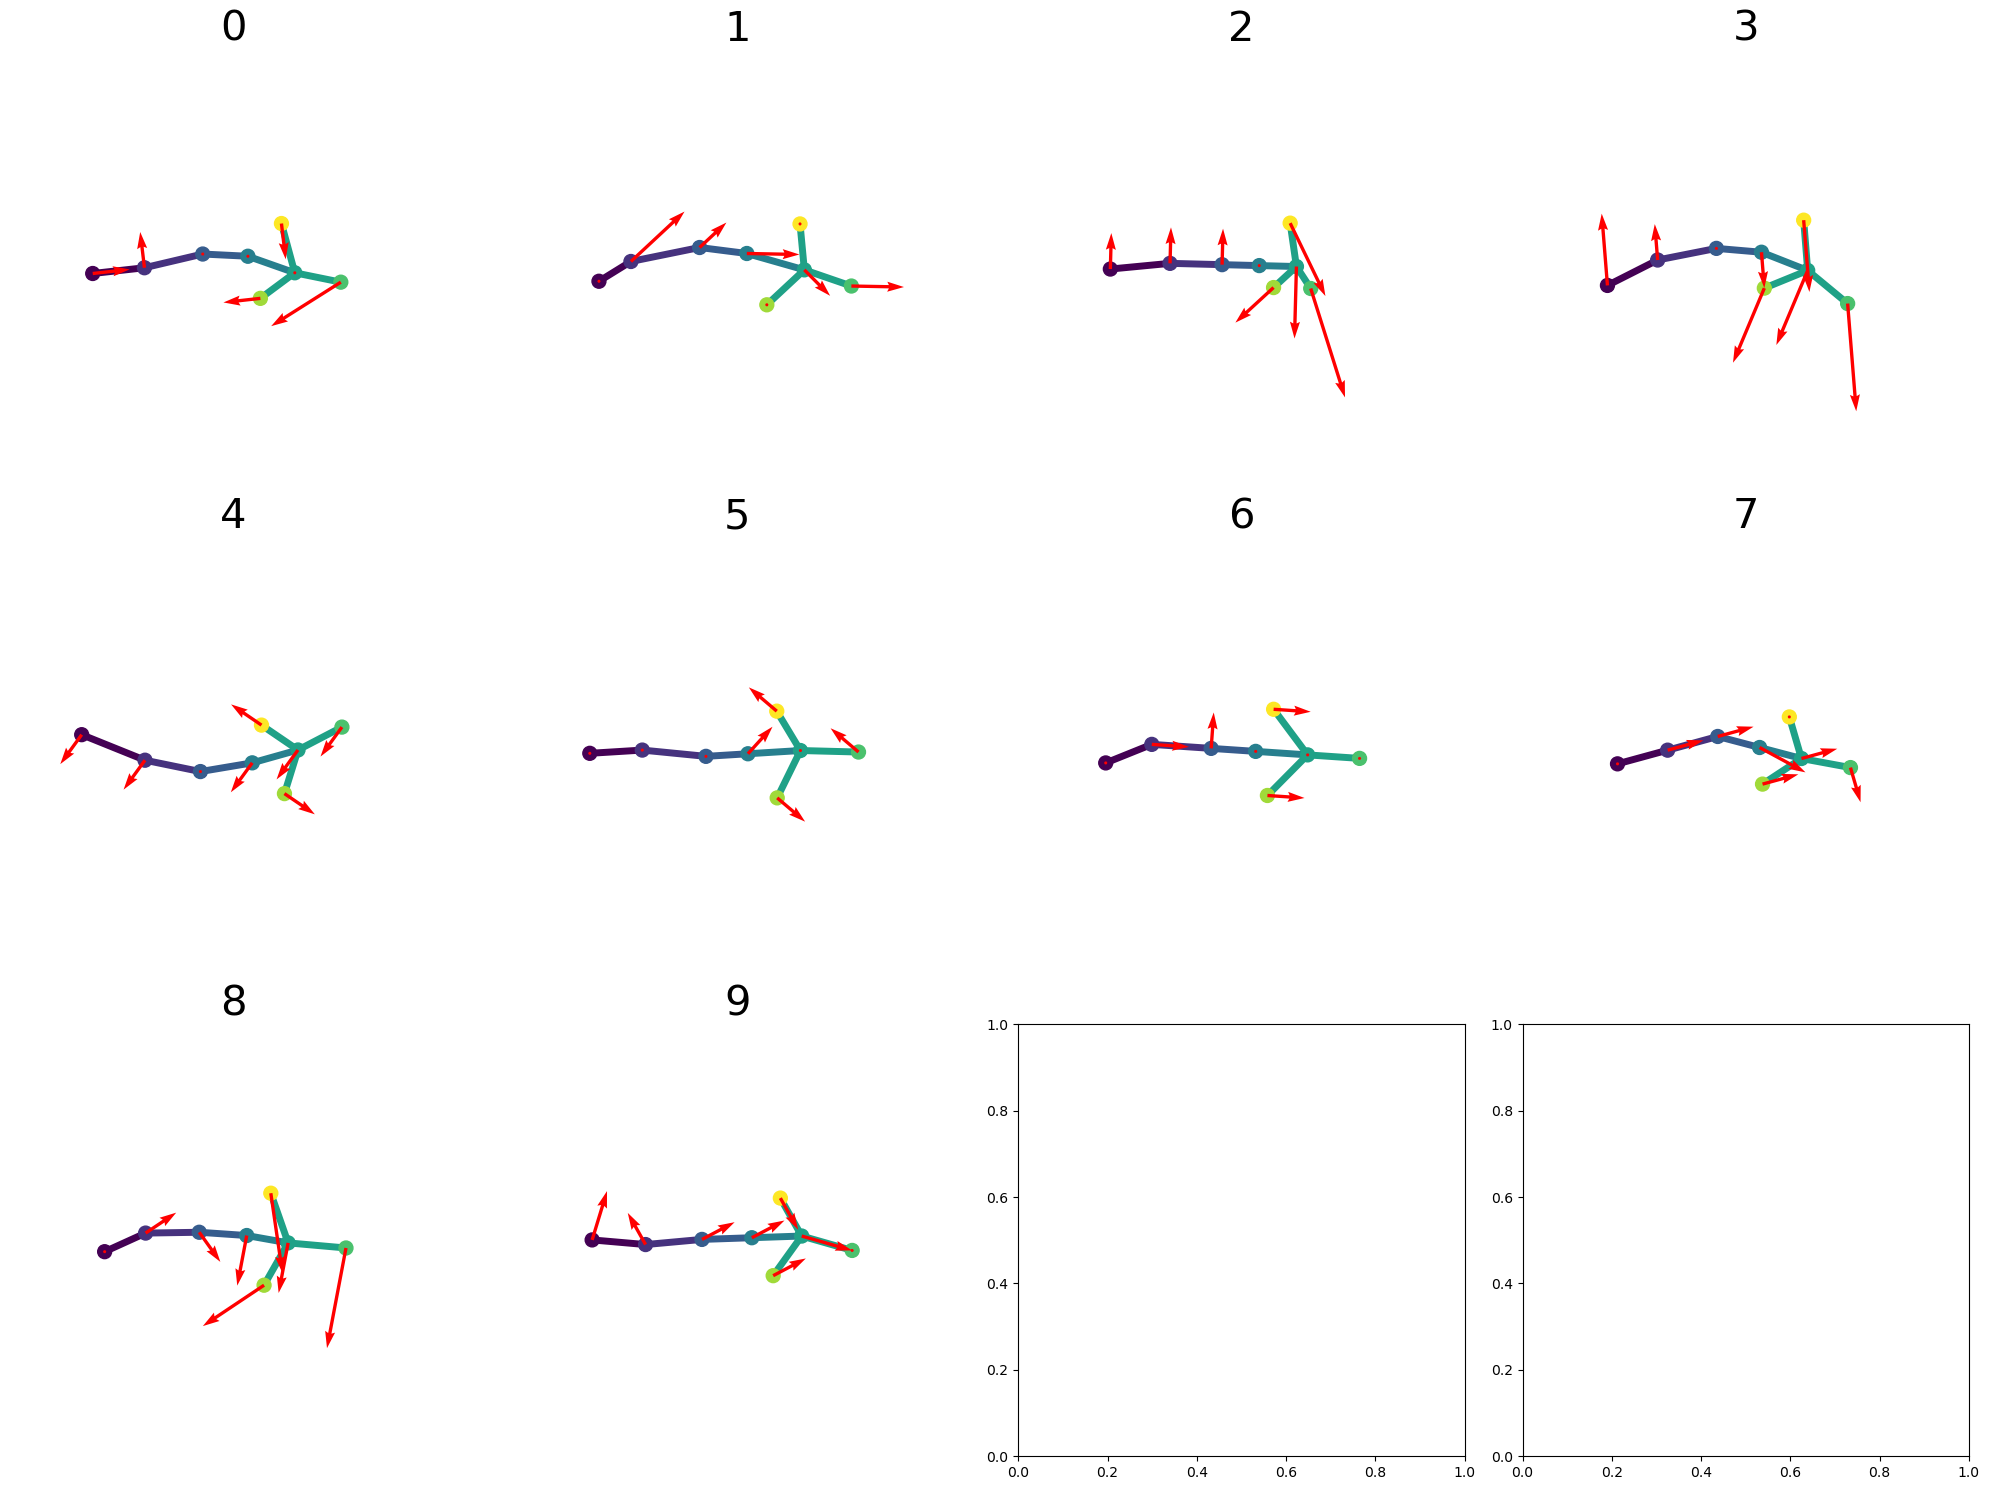

In [ ]:
state_dim = 16
action_dim = 16
n_task = 10
device = torch.device('cpu')
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, device)
replay_buffer_path = f'./kms/test_data_24.pth'
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
assert np.isclose(replay_buffer.state[0:5]+replay_buffer.action[0:5], replay_buffer.next_state[0:5]).all()
sample_and_plot(replay_buffer, 10)
idx2 = np.array([6514, 5467,  4947,  5428,  7586, 13119, 11209, 12561, 2036, 10781])

In [ ]:
a = np.load('model/kms/spedersac/S_f128_datasets200a200_CD_norm1_ctrl/0/args_kwargs.npy', allow_pickle=True)
print(a)

Filter syllable 2 & 4 based on rotating direction

In [ ]:
# from visualize import plot_gif
from visualize import is_clockwise
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
replay_buffer_filter = buffer.ReplayBuffer(state_dim, action_dim, 100000)
for i in [2]:
    all_idxs = np.where(test_buffer.task==i)[0]
    transition = np.where(np.diff(all_idxs)>1)[0]
    # print(transition)
    transition_list = np.concatenate(([0], transition))
    print(len(transition_list))
    for j in range(len(transition_list)-1):
        start = all_idxs[transition_list[j]+1]
        end = all_idxs[transition_list[j+1]]
        if start >= end-1:
            continue
        state_seqs = test_buffer.state[start:end]
        clockwise, pc_to_plot = is_clockwise(state_seqs)
        if (i==2 and clockwise):
            for k in range(start, end):
                if k == end-1:
                    done = 1
                else:
                    done = 0
                replay_buffer_filter.add(test_buffer.state[k], test_buffer.action[k], test_buffer.next_state[k], 
                                         test_buffer.reward[k], done, test_buffer.task[k], test_buffer.next_task[k])
print(replay_buffer_filter.size)
torch.save(replay_buffer_filter.state_dict(), './kms/replay_buffer_mildnormalized_state200_action200_filter2.pth')

In [ ]:
from visualize import get_edges
def plot_figure_PC(state, save_path):
  # state: [state_dim, ]
  edges, state_name, n_dim = get_edges(state.shape[-1])
  fig, axis = plt.subplots(1, 1, figsize=(5, 6))
  state_to_plot = state.reshape(-1, 2)
  state_to_plot -= state_to_plot.mean(axis=0)
  _, _, vhs = np.linalg.svd(state_to_plot)
  pc_to_plot = vhs[0]
  cmap = plt.cm.get_cmap('viridis')
  keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
  xmin = -0.2
  xmax = 0.2
  ymin = -0.2
  ymax = 0.2
  # xmin = min(state_to_plot[:, 0].min(), pc_to_plot[0])
  # xmax = max(state_to_plot[:, 0].max(), pc_to_plot[0])
  # ymin = min(state_to_plot[:, 1].min(), pc_to_plot[1])
  # ymax = max(state_to_plot[:, 1].max(), pc_to_plot[1])
  axis.set_xlim(xmin, xmax)
  axis.set_ylim(ymin, ymax)
  for p1, p2 in edges:
    axis.plot(
        *state_to_plot[(p1, p2),:].T,
        color=keypoint_colors[p1],
        linewidth=5.0)
  axis.scatter(
      *state_to_plot.T,
      c=keypoint_colors,
      s=100)
  axis.quiver(0, 0, pc_to_plot[0], pc_to_plot[1], angles='xy', scale_units='xy', scale=10, color='r')
  if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
  plt.savefig(save_path)

state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/test_data_continuous_a200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
state = test_buffer.state[90]
save_path = './figure/kms/pc.png'
plot_figure_PC(state, save_path)

Pick out gif from dataset

In [ ]:
from visualize import plot_gif
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200_filter2.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
for j in [2]:

    all_idxs = np.where(test_buffer.task==j)[0]
    print(all_idxs)
    transition = np.where(np.diff(all_idxs)>1)[0]
    print(transition)
    transition_list = np.concatenate(([0], transition))
    print(transition_list)
    i=0
    while i<10:
        k = np.random.randint(0, len(all_idxs)-10)
        start = all_idxs[k]
        end = all_idxs[k]+10
        done_seqs = test_buffer.done[start:end]
        if np.sum(done_seqs) > 0:
            continue
        state_seqs = test_buffer.state[start:end]
        plot_gif(state_seqs, f'./figure/kms/task_gif/task_{j}/{i}.gif')
        i += 1
        

In [ ]:
from visualize import plot_gif
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))

for j in range(n_task):
    all_idxs = np.where(test_buffer.task==j)[0]
    # print(all_idxs)
    transition = np.where(np.diff(all_idxs)>1)[0]
    # print(transition)
    transition_idx = all_idxs[transition]
    all_done = test_buffer.done[transition_idx]
    done_zero = np.where(all_done==0)[0]
    # print(transition_idx[done_zero])
    # original_idx = transition_idx[done_zero]
    # print(original_idx)
    # print(replay_buffer.state[original_idx])
    # print()
    # print(all_done.reshape(-1))
    # print(np.all(np.isclose(all_done, 1)))
    # continue
    transition_list = np.concatenate(([0], transition))
    print(transition_list)
    i=0
    while i<10:
        
        k = np.random.randint(0, len(transition_list)-1)
        start = all_idxs[transition_list[k]+1]
        end = all_idxs[transition_list[k+1]]
        print(start, end)
        if start == end:
            continue
        state_seqs = test_buffer.state[start:end]
        plot_gif(state_seqs, f'./figure/kms/task_gif/task_{j}/{i}.gif')
        i += 1
        
# state_seqs = replay_buffer.state[1172:1182]
# plot_gif(state_seqs, f'./figure/kms/task2_continuous.gif')

In [ ]:
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
print(test_buffer.task[1150:1165].reshape(-1))
print(test_buffer.done[1150:1165].reshape(-1))

In [ ]:
def check_multiple_step_rollout(lr, syllable, replay_buffer):
    syllable_idx = np.where(replay_buffer.task == syllable)[0]
    transition = np.where(np.diff(syllable_idx) != 1)[0]+1
    print(len(transition))
    state_seqs = [None] * (len(transition)-1)
    for i in range(len(transition)-1):
        # print(transition[i], transition[i+1])
        # print(syllable_idx[transition[i]:transition[i+1]-1])
        state_seqs[i] = replay_buffer.state[syllable_idx[transition[i]:transition[i+1]-1]]
        assert state_seqs[i].shape[-1] == 16
    all_error = np.zeros(len(transition)-1)
    for i in range(len(state_seqs)):
        imitation_state_seq = np.zeros_like(state_seqs[i])
        # print(state_seqs[i], transition[i], syllable_idx[transition[i]:transition[i+1]-1])
        imitation_state_seq[0] = state_seqs[i][0]
        for j in range(1, state_seqs[i].shape[0]):
            imitation_state_seq[j] = lr.predict(imitation_state_seq[j-1].reshape(1, -1)).reshape(-1)
        error = np.mean(np.abs(imitation_state_seq - state_seqs[i]))
        # print(i, error)
        all_error[i] = error
    # print('all:', all_error.mean())
    return all_error.mean()

Show the fitting result of linear model

In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif
lr = LinearRegression()
test_buffer_path = './kms/train_data.pth'
replay_buffer_state_dict = torch.load(test_buffer_path)
state_dim, action_dim = 16, 80
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
test_buffer.load_state_dict(replay_buffer_state_dict)
state = replay_buffer_state_dict['state']
action = replay_buffer_state_dict['action']
next_state = replay_buffer_state_dict['next_state']
print(state.shape, next_state.shape)
# sa_input = np.concatenate([state, action], axis=1)
# split train and test buffer
# train_buffer_size = int(0.8 * len(znormalized_state))
# print(train_buffer_size)
lr.fit(state, action)
test_buffer_path = './kms/test_data.pth'
test_buffer_state_dict = torch.load(test_buffer_path)
test_state = test_buffer_state_dict['state']
test_action = test_buffer_state_dict['action']
test_next_state = test_buffer_state_dict['next_state']
test_action_pred = lr.predict(test_state)
error = np.abs(test_action_pred - test_action)
print(error.shape)
error_mean = np.mean(error, axis=0)
print(error_mean, error_mean.mean())
torch.save(lr, './kms/linear_model_discrete.pth')


In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif
from visualize import plot_gif_all_syllables
from utils.util import unpack_batch
train_buffer_path = './kms/train_data_continuous_a200.pth'
train_buffer_state_dict = torch.load(train_buffer_path)
state_dim, action_dim = 16, 16
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
train_buffer.load_state_dict(train_buffer_state_dict)
test_buffer_path = './kms/test_data_continuous_a200.pth'
replay_buffer_state_dict = torch.load(test_buffer_path)
state_dim, action_dim = 16, 16
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
test_buffer.load_state_dict(replay_buffer_state_dict)
timestep = 30
state_dim = action_dim = 16
n_syllable = 10
state_seqs = np.zeros((n_syllable, timestep, state_dim))
# all_error = np.zeros((10,))
batch_size = 512
for syllable in range(n_syllable):
    print('syllable:', syllable)
    lr = LinearRegression()
    state_set = []
    action_set = []
    for j in range(10):
        batch = train_buffer.sample(batch_size)
        state, action, next_state, reward, _, task, next_task = unpack_batch(batch)
        all_idx = np.where(task.cpu().numpy() == syllable)[0]
        state_set.append(state[all_idx].cpu().numpy())
        action_set.append(action[all_idx].cpu().numpy())
    state_set = np.concatenate(state_set, axis=0)
    action_set = np.concatenate(action_set, axis=0)
    lr.fit(state_set, action_set)
    # new_action_pred = lr.predict(state)
    # error = np.abs(new_next_state_pred - next_state)
    # print(error.shape)
    # error_mean = np.mean(error, axis=0)
    # print(error_mean, error_mean.mean())
    # all_error[syllable] = check_multiple_step_rollout(lr, syllable, replay_buffer)
    # print(syllable, all_error[syllable])
    sample_idx = 90
    state = test_buffer.state[sample_idx]
    state_seqs[syllable, 0] = state
    for i in range(1, timestep):
        action = lr.predict(state.reshape(1, -1))
        # print('action:', action.shape)
        next_state = action + state
        state_seqs[syllable, i] = next_state
        state = next_state
plot_gif_all_syllables(state_seqs, f'./figure/kms/linear_state_pred90/task.gif')
# plot_gif(state_seqs, f'./figure/kms/linear_state_pred90/{syllable}task.gif')
# print(state_seqs[0].shape)
    # np.save(f'./kms/s_mean.npy', state_seqs[0].reshape(-1,2))
# print('all:', all_error.mean())

Load replay buffer and normalize it

In [ ]:
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_continuous_allaction.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))

In [ ]:
linear_model = torch.load('./kms/linear_model_discrete.pth')
linear_model.predict(test_buffer.state[:5])

In [ ]:
scale_factor = 200
action_all = test_buffer.action
print(action_all.shape[0])
# syllable_indicator = (replay_buffer.task == 3).squeeze()
# print(len(np.where(all_idx)[0]))
filtered_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
size = test_buffer.size
# filtered_replay_buffer.state = replay_buffer.state
# filtered_replay_buffer.next_state = replay_buffer.next_state
# assert np.isclose(replay_buffer.state + replay_buffer.action, replay_buffer.next_state).all()
new_state = test_buffer.state
new_next_state = test_buffer.next_state

state_mean = np.mean(np.concatenate([new_state, new_next_state[-2:]], axis=0))
print(state_mean)
mildnormalized_state = (new_state - state_mean) / scale_factor
filtered_replay_buffer.state = mildnormalized_state

mildnormalized_next_state = (new_next_state - state_mean) / scale_factor
filtered_replay_buffer.next_state = mildnormalized_next_state

new_action = test_buffer.action
filtered_replay_buffer.action = new_action/scale_factor
# mildnormalized_action = new_action / scale_factor
# filtered_replay_buffer.action = mildnormalized_action

filtered_replay_buffer.reward = test_buffer.reward
filtered_replay_buffer.done = test_buffer.done
filtered_replay_buffer.task = test_buffer.task
filtered_replay_buffer.next_task = test_buffer.next_task
filtered_replay_buffer.size = test_buffer.size
filtered_replay_buffer.ptr = 0

# assert np.isclose(filtered_replay_buffer.state + filtered_replay_buffer.action, filtered_replay_buffer.next_state).all()
torch.save(filtered_replay_buffer.state_dict(), './kms/replay_buffer_mildnormalized_state200_action200.pth')

Load from the whole dataset and split it into trainset and testset

In [ ]:
state_dim = 16
action_dim = 16
n_task = 10
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load('./kms/replay_buffer_mildnormalized_state200_action200_filter2.pth'))
print(np.unique(test_buffer.action))
# action_onehot = np.eye(5)[replay_buffer.action.astype(int)]
assert np.isclose(test_buffer.state + test_buffer.action, test_buffer.next_state).all()
# print(action_onehot.shape)
# replay_buffer.action = action_onehot.reshape(action_onehot.shape[0], -1)
# replay_buffer.action = replay_buffer.action.astype(int)

In [5]:
idx = np.arange(test_buffer.size)
# np.random.shuffle(idx)
train_idx = idx[:int(test_buffer.size * 0.8)]
test_idx = idx[int(test_buffer.size * 0.8):]
train_data = {}
test_data = {}
key = ['state', 'action', 'next_state', 'reward', 'done', 'task', 'next_task']
for k in key:
    train_data[k] = test_buffer.__getattribute__(k)[train_idx]
    test_data[k] = test_buffer.__getattribute__(k)[test_idx]
train_data['size'] = len(train_idx)
test_data['size'] = len(test_idx)
train_data['ptr'] = 0
test_data['ptr'] = 0
# np.savez('./kms/train_data_sequential_discrete_action04.npz', **train_data)
# np.savez('./kms/test_data_sequential_discrete_action04.npz', **test_data)
torch.save(train_data, './kms/train_data_2_only.pth')
torch.save(test_data, './kms/test_data_2_only.pth')
print(len(train_idx), len(test_idx))
print(np.unique(train_data['action'], return_counts=True))
print(np.unique(test_data['action'], return_counts=True))
print(np.unique(train_data['done'], return_counts=True))
print(np.unique(test_data['done'], return_counts=True))

27906 6977
(array([-0.46, -0.26, -0.2 , -0.18, -0.17, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
        0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
        0.16,  0.17,  0.19,  0.22]), array([     1,      1,      1,      1,      2,      5,      2,      3,
            6,      9,     19,     11,     17,     33,     44,     89,
          235,   1301,   9254,  71142, 274928,  76854,  10672,   1413,
          239,     70,     40,     32,     20,     16,     14,      9,
            3,      2,      3,      1,      1,      1,      1,      1]))
(array([-0.19, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
        0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,
        0.13,  0.15,  0.18]), array([    2,     2,     1,     3,     7,     4,     9,     9,     7,
   

In [ ]:
3795722/(94596+784483+3795722+823329+101838)

Load from raw data and creates dataset

In [ ]:
dlc_sample = pickle.load(open('./kms/dlc_sample.pkl', 'rb'))
print(dlc_sample.keys())
print(dlc_sample['coordinates'].keys())
print(dlc_sample['coordinates']['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'].shape)

In [ ]:
results = h5py.File('./kms/results.h5', 'r')
print(np.array(results['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000']['syllable']))

In [ ]:
syllables = {k:v['syllable'] for k,v in results.items()}
print(syllables)

This proves that the states are sorted by instance frequency

In [ ]:
# stateseqs = {
#         'name1': np.array([1, 1, 2, 2, 2, 3]),
#         'name2': np.array([0, 0, 0, 1])}
stateseq_flat = np.hstack(list(syllables.values()))
state_onsets = np.pad(np.diff(stateseq_flat).nonzero()[0] + 1, (1, 0))
stateseq_flat = stateseq_flat[state_onsets]
counts = np.bincount(stateseq_flat, minlength=77)
print(counts[:25])
print(np.all(np.diff(counts)<=0))


In [ ]:
def rotate(state, action, next_state, reward, done, task, next_task):
    theta = np.random.uniform(0, 2*np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_action = (action.reshape(-1,2) @ rotation_matrix).reshape(-1)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
def shift(state, action, next_state, reward, done, task, next_task):
    shift = np.random.randn(2)
    # print('shift:', shift)
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) + shift).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) + shift).reshape(-1)
    new_action = action
    # print('state:', state, new_state)
    # print('action:', action, new_action)
    # print('next_state:', next_state, new_next_state)
    # print('compare:', new_state + new_action, new_next_state)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
    

In [ ]:
bodyparts=[
    'tail', 'spine4', 'spine3', 'spine2', 'spine1',
    'head', 'nose', 'right ear', 'left ear']
use_bodyparts=[
        'spine4', 'spine3', 'spine2', 'spine1',
        'head', 'nose', 'right ear', 'left ear']
use_bodyparts_idx = [bodyparts.index(bp) for bp in use_bodyparts]
state_dim = len(use_bodyparts) * 2
action_dim = len(use_bodyparts) * 2
n_task = 10 # filter out some non-frsequent tasks
extra_augmentation_step = 1
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, 'cpu')
for name in dlc_sample['coordinates'].keys():
    print(name)
    for i in range(len(dlc_sample['coordinates'][name])-1):
        state = np.array(dlc_sample['coordinates'][name][i][use_bodyparts_idx].flatten())
        next_state = np.array(dlc_sample['coordinates'][name][i+1][use_bodyparts_idx].flatten())
        action = next_state - state
        task = np.array(results[name]['syllable'][i])
        next_task = np.array(results[name]['syllable'][i+1])
        ###这个done是否和transition_point相吻合？
        done = np.where(next_task != task, 1, 0)
        assert not np.all(np.isnan(state))
        if task < n_task and next_task < n_task and np.all(np.abs(action) <= 4):
            original_replay_buffer.add(state, action, next_state, 0, done, task, next_task)
            # for j in range(extra_augmentation_step):
            #     an_item = shift(*rotate(state, action, next_state, 0, 0, task, next_task))
            #     assert np.isclose(an_item[0] + an_item[1], an_item[2]).all()
            #     original_replay_buffer.add(*an_item)
print(original_replay_buffer.size)



In [ ]:
print(np.unique(original_replay_buffer.action, return_counts=True))
torch.save(original_replay_buffer.state_dict(), './kms/replay_buffer_discrete.pth')

In [ ]:
length = original_replay_buffer.size
print(original_replay_buffer.state[:10000])

This normalization scales every dimension with the same factor to make sure that the relative position is not discarded

In [ ]:
# normalize
all_state = original_replay_buffer.state[:length]
all_next_state = original_replay_buffer.next_state[:length]
state_min = np.concatenate([all_state, all_next_state[-1:]]).min()
state_max = np.concatenate([all_state, all_next_state[-1:]]).max()
state_range = state_max - state_min
normalized_state = (all_state - state_min) / state_range * 2 - 1
normalized_next_state = (all_next_state - state_min) / state_range * 2 - 1
# print(normalized_next_state.min(0), normalized_next_state.max(0))
all_action = original_replay_buffer.action[:length]
action_min = all_action.min()
action_max = all_action.max()
action_range = action_max - action_min
normalized_action = (all_action - action_min) / action_range * 2 - 1
# for i in range(state_dim):
#     print(all_action[:100,i])
#     plt.hist(all_action[:, i], bins=100)
#     plt.show()
for i in range(200):
    print(all_action[i].max(), end=' ')
####ACTION

In [ ]:
shuffle_idx = np.arange(length)
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:int(length*0.8)]
test_idx = shuffle_idx[int(length*0.8):]
train_state = torch.FloatTensor(normalized_state[train_idx])
train_action = torch.FloatTensor(normalized_action[train_idx])
train_next_state = torch.FloatTensor(normalized_next_state[train_idx])
train_task = torch.Tensor(original_replay_buffer.task[train_idx])
train_next_task = torch.Tensor(original_replay_buffer.next_task[train_idx])
train_reward = torch.zeros((train_state.shape[0], 1))
train_done = torch.zeros((train_state.shape[0], 1))
train_buffer_state_dict = {'state': train_state, 
                           'action': train_action, 
                           'next_state': train_next_state, 
                           'reward': train_reward, 
                           'done': train_done, 
                           'task': train_task, 
                           'next_task': train_next_task,
                           'size': len(train_idx),
                           'ptr': 0}
test_state = torch.FloatTensor(normalized_state[test_idx])
test_action = torch.FloatTensor(normalized_action[test_idx])
test_next_state = torch.FloatTensor(normalized_next_state[test_idx])
test_task = torch.Tensor(original_replay_buffer.task[test_idx])
test_next_task = torch.Tensor(original_replay_buffer.next_task[test_idx])
test_reward = torch.zeros((test_state.shape[0], 1))
test_done = torch.zeros((test_state.shape[0], 1))
test_buffer_state_dict = {'state': test_state, 
                          'action': test_action, 
                          'next_state': test_next_state, 
                          'reward': test_reward, 
                          'done': test_done, 
                          'task': test_task, 
                          'next_task': test_next_task,
                          'size': len(test_idx),
                          'ptr': 0}



In [ ]:
torch.save(train_buffer_state_dict, './kms/train_buffer_state_dict.pth')
torch.save(test_buffer_state_dict, './kms/test_buffer_state_dict.pth')
print(train_state.shape, test_state.shape)

In [ ]:
normalize_dict = {
    'state_min': state_min,
    'state_max': state_max,
    'action_min': action_min,
    'action_max': action_max
}
torch.save(normalize_dict, './kms/normalize_dict.pth')

In [ ]:
task_all = original_replay_buffer.task
freq = np.zeros((int(task_all.max()), ))
print(len(freq))
for i in range(len(freq)):
    freq[i] = len(task_all[task_all == i])
print(np.argsort(freq))

In [ ]:
state_dim = 54
action_dim = 54
n_task = 60
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
test_buffer_path = f'./data/replay_buffer_18body_normalized_new.pth'
original_replay_buffer.load_state_dict(torch.load(test_buffer_path))

state_all, action_all, next_state_all, task_all, next_task_all, reward_all, done_all = \
    original_replay_buffer.state, original_replay_buffer.action, original_replay_buffer.next_state, original_replay_buffer.task,\
    original_replay_buffer.next_task, original_replay_buffer.reward, original_replay_buffer.done

length = original_replay_buffer.size
print(length)
syllable_idx = np.arange(length)
np.random.shuffle(syllable_idx)
train_idx = torch.tensor(syllable_idx[:int(0.8*length)])
test_idx = torch.tensor(syllable_idx[int(0.8*length):])
print(len(train_idx), len(test_idx))
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
for key in original_replay_buffer.state_dict().keys():
    if key != 'ptr' and key != 'size':
        print(key)
        train_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[train_idx])
        test_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[test_idx])
train_buffer.size = len(train_idx)
test_buffer.size = len(test_idx)
print(train_buffer.size, test_buffer.size)
train_buffer_path = './data/replay_buffer_18body_normalized_new_train.pth'
test_buffer_path = './data/replay_buffer_18body_normalized_new_test.pth'
torch.save(train_buffer.state_dict(), train_buffer_path)
torch.save(test_buffer.state_dict(), test_buffer_path)
print('Save')

In [ ]:
def load_rat7m():
    state_dim = 8
    action_dim = 8
    replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000)
    replay_buffer_path = f'../../rat7m/replay_buffer_3sigma_tanh.pth'
    replay_buffer.load_state_dict(torch.load(replay_buffer_path))
    print(f'Replay buffer loaded from {replay_buffer_path}')
    return replay_buffer, state_dim, action_dim
original_replay_buffer, state_dim, action_dim = load_rat7m()
print(original_replay_buffer.state[:5], original_replay_buffer.action[:5])

In [ ]:
matrix_notxyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalized_lasso_1e-2/0/ig_matrix_agg.npy')
matrix_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
corr = np.corrcoef(matrix_notxyz.flatten(), matrix_xyz.flatten())[0, 1]
print(corr)

In [ ]:
import torch

phi_hidden_dim = 10
input_dim = 9  # suppose we have 2 groups, each with xyz => 2*3=6
W = torch.randn(phi_hidden_dim, input_dim)

# Original approach
W_orig = W.reshape(phi_hidden_dim, input_dim//3, 3)
orig_lasso = torch.sqrt(W_orig.pow(2).sum(dim=0).sum(dim=-1)).sum()

# New approach
W_t = W.T.reshape(-1, phi_hidden_dim*3)
new_lasso = torch.norm(W_t, dim=1).sum()

print("orig_lasso =", orig_lasso.item())
print("new_lasso  =", new_lasso.item())

In [ ]:
state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
                'SpineL','HipL','HipR','ElbowL','ArmL',
                'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
                'KneeL','ShinL','ShinR']
# When I transfer the skeleton into edges, Please refer to the following skeleton.

state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
              'SpineL','HipL','HipR','ElbowL','ArmL',
              'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
              'KneeL','ShinL','ShinR']

skeleton = [('HeadF', 'HeadB'), ('HeadF', 'HeadL'), ('HeadB', 'HeadL'),
            ('HeadB', 'SpineF'), ('HeadL', 'SpineF'), ('SpineF', 'SpineM'),
            ('SpineM', 'SpineL'), ('SpineF', 'ShoulderL'), ('ShoulderL', 'ElbowL'),
            ('ElbowL', 'ArmL'), ('SpineF', 'ShoulderR'), ('ShoulderR', 'ElbowR'),
            ('ElbowR', 'ArmR'), ('SpineM', 'HipL'), ('HipL', 'KneeL'),
            ('KneeL', 'ShinL'), ('SpineM', 'HipR'), ('HipR', 'KneeR'),
            ('KneeR', 'ShinR')]
edges = []
for i in skeleton:
  edges.append((state_name.index(i[0]), state_name.index(i[1])))

import joblib
import numpy as np
import matplotlib.pyplot as plt
pca = joblib.load('./pca.p')
print(pca)

In [ ]:
def center_embedding(n):
    """
    Generates a matrix ``Gamma`` that maps from a (n-1)-dimensional
    vector space  to the space of k-tuples with zero mean

    Parameters
    ----------
    n : int
        Number of keypoints.

    Returns
    -------
    Gamma: jax array of shape (n, n - 1)
        Matrix to map to centered embedded space.
    """
    X = np.tril(np.ones((n, n)), k=-1)[1:]
    X = np.eye(n)[1:] - X / X.sum(1)[:, None]
    X = X / np.sqrt((X**2).sum(1))[:, None]
    return X.T
Gamma = np.array(center_embedding(len(state_name)))

ymean = Gamma @ pca.mean_.reshape(len(state_name)-1, -1)
ymean[state_name.index('HeadB'), 2] -= 10
ymean[state_name.index('HeadF'), 0] += 10
ymean[state_name.index('SpineL'), 2] += 20
ymean[state_name.index('ShoulderL'), 0] += 20
ymean[state_name.index('ElbowL'), 0] += 20
ymean[state_name.index('ElbowL'), 2] += 10
ymean[state_name.index('ArmL'), 0] += 30
ymean[state_name.index('ArmL'), 2] += 10
ymean[state_name.index('ArmR'), 0] += 10
ymean[state_name.index('HipL'), 2] += 10
ymean[state_name.index('HipL'), 0] += 30
ymean[state_name.index('KneeL'), 2] += 10
ymean[state_name.index('KneeL'), 0] += 30
ymean[state_name.index('ShinL'), 2] += 10
ymean[state_name.index('ShinL'), 0] += 30
ymean[state_name.index('HipR'), 0] -= 10
ymean[state_name.index('HipR'), 2] += 10
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
dims = [0, 2]
dims, name = [0,2], 'xz'
cmap = plt.cm.get_cmap('viridis')
keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
# print(keypoint_colors)
n_bodyparts = len(state_name)
ig_matrix_agg_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
for e in edges:
    axes.plot(
        *ymean[:, dims][e,:].T,
        color=keypoint_colors[e[0]],
        linewidth=5.0,
        zorder=0)
node_colors = ['blue' if ig_matrix_agg_xyz[0, j] < 0 else 'red' for j in range(2*n_bodyparts)]
axes.scatter(
        *ymean[:, dims].T,
        c=node_colors[:n_bodyparts],
        s=np.abs(ig_matrix_agg_xyz[0, :n_bodyparts])*120,
        zorder=1)
axes.axis('off')
plt.show()

In [ ]:
np.save('ymean.npy', ymean)